# Importing necessary libraries

These are third-party libraries that we used.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from loess import loess_1d
from mpl_toolkits.mplot3d import Axes3D
from plyfile import PlyData, PlyElement
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statistics import mean

# Helper functions

These are functions that we wrote to make life easier throughout the notebook.

In [2]:
def annotation_line(ax, xmin, xmax, y, text, ytext = 0, linecolor = 'red', linewidth = 1, fontsize = 12):
    ax.annotate('',
                xy=(xmin, y),
                xytext=(xmax, y),
                xycoords='data',
                textcoords='data',
                arrowprops={'arrowstyle': '|-|',
                            'color': linecolor, 
                            'linewidth':linewidth
                           }
               )
    
    ax.annotate('', 
                xy=(xmin, y), 
                xytext=(xmax, y), 
                xycoords='data', 
                textcoords='data',
                arrowprops={'arrowstyle': '<->', 
                            'color': linecolor, 
                            'linewidth':linewidth
                           }
               )

    xcenter = xmin + (xmax - xmin) / 2
    
    if ytext == 0:
        ytext = y + (ax.get_ylim()[1] - ax.get_ylim()[0]) / 2

    ax.annotate(text, xy=(xcenter,ytext), ha='center', va='center', fontsize=fontsize)
    
    
def find_max_length_list(l):
    list_len = [len(i) for i in l]
    return max(list_len)
    
    
def pad_list_to_length_with(a, N, x = 0):
    return a + [x] * (N - len(a))

def get_erosion_class_based_on_x_coordinate(x):
    if x > 170 and x < 320:
        return 2
    elif x > 340 and x < 500:
        return 2
    elif x > 520 and x < 560:
        return 2
    elif x > 640 and x < 690:
        return 2
    elif x > 740 and x < 840:
        return 1
    else:
        return 0

# Reading the data

The data is contained in a .ply file, which we need to parse into something that Python can actually use.

In [3]:
plydata = PlyData.read('data/220513_132657_binary.ply')
plydata

PlyData((PlyElement('vertex', (PlyProperty('x', 'double'), PlyProperty('y', 'double'), PlyProperty('z', 'double')), count=16896000, comments=[]),), text=False, byte_order='<', comments=[], obj_info=[])

So there are 3 coordinates (x, y and z) and almost 17 million rows. Rather impressively, there are almost 10 million rows indicating a missed measurement or no signal. These are measurements we want to delete. They don't have value to use and they will only act as (sever) noise to our machine learning models later on.

In [4]:
plydata.elements[0].count - len(plydata['vertex']['z'].nonzero()[0])

9260808

In [5]:
indices_to_remove = plydata['vertex']['z'] == 0

# https://stackoverflow.com/a/24553551

In [6]:
x = np.delete(plydata['vertex']['x'], indices_to_remove)
print(len(x))
print(x)

7635192
[920.97997665 920.97997665 920.97997665 ... 373.10999632 373.10999632
 373.10999632]


Blade measurements start on approx. 10 cm and then run to approx 110 cm. These values correspond with the x measurements, so X is therefore the location of the camera on the blade.

That means that Y is be the vertical axis (chord of the blade) and Z the depth of the measurement. Throughout this notebook, we are mostly interested in the Z values. These are the ones that should actually show the erosion.

But first, let's make sure that our Y and Z arrays also have their corresponding 0-Z-values removed.

In [7]:
y = np.delete(plydata['vertex']['y'], indices_to_remove)
z = np.delete(plydata['vertex']['z'], indices_to_remove)

# Preliminary exploration

Let's create a few plots to look at our data and how it is distributed.

Text(0.5, 1.0, 'Z Axis')

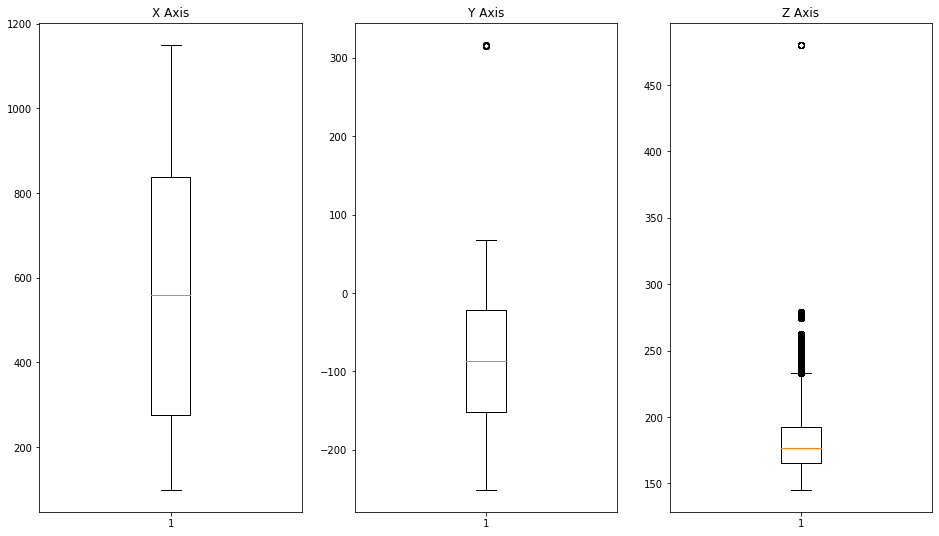

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(16,9))

axs[0].boxplot(x)
axs[0].set_title('X Axis')

axs[1].boxplot(y)
axs[1].set_title('Y Axis')

axs[2].boxplot(z)
axs[2].set_title('Z Axis')

The boxplots show what we would expect. The Y-values are not centered around 0, which means the blade wasn't exactly in the middle of the camera. But this should not be a problem and can actually be constructed as realistic: the drone will rarely be in the exact middle of the blade while scanning.

There are almost no weird data points, except for some lone outlier on the Y-axis and few noisy Z-values. Let's remove the outlier from the Y-axis and everything above 250 from the Z-axis. That way our data is mostly noise-free and can be used to train machine learning models.

In [9]:
indices_to_remove = (y > 100)

x = np.delete(x, indices_to_remove)
y = np.delete(y, indices_to_remove)
z = np.delete(z, indices_to_remove)

indices_to_remove = (z > 240)

x = np.delete(x, indices_to_remove)
y = np.delete(y, indices_to_remove)
z = np.delete(z, indices_to_remove)

Let's see how the boxplots have been adjusted. With the outliers and noise removed, it all seems in order.

Text(0.5, 1.0, 'Z Axis')

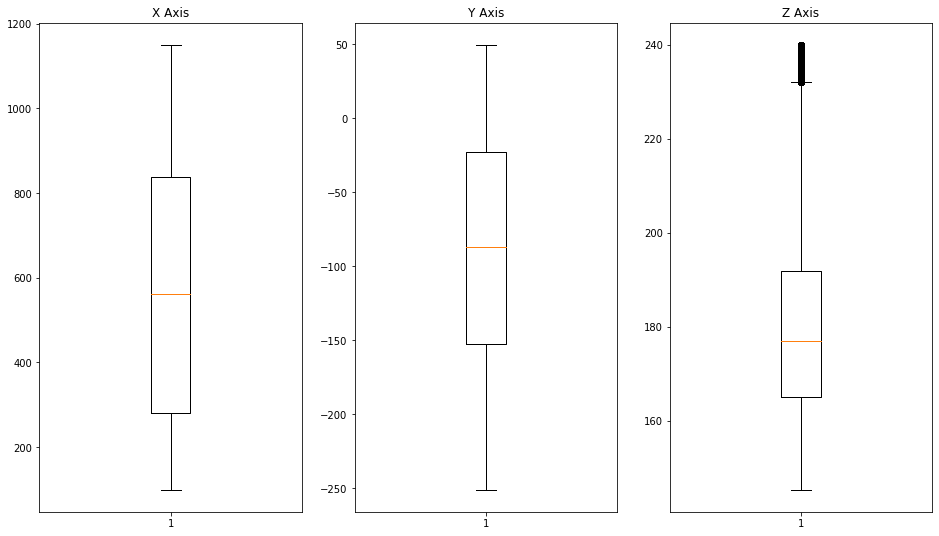

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(16,9))

axs[0].boxplot(x)
axs[0].set_title('X Axis')

axs[1].boxplot(y)
axs[1].set_title('Y Axis')

axs[2].boxplot(z)
axs[2].set_title('Z Axis')

Now let's look what the data actually shows us: the blade itself! TU Delft was kind enough to send an image of the blade with erosion visible:

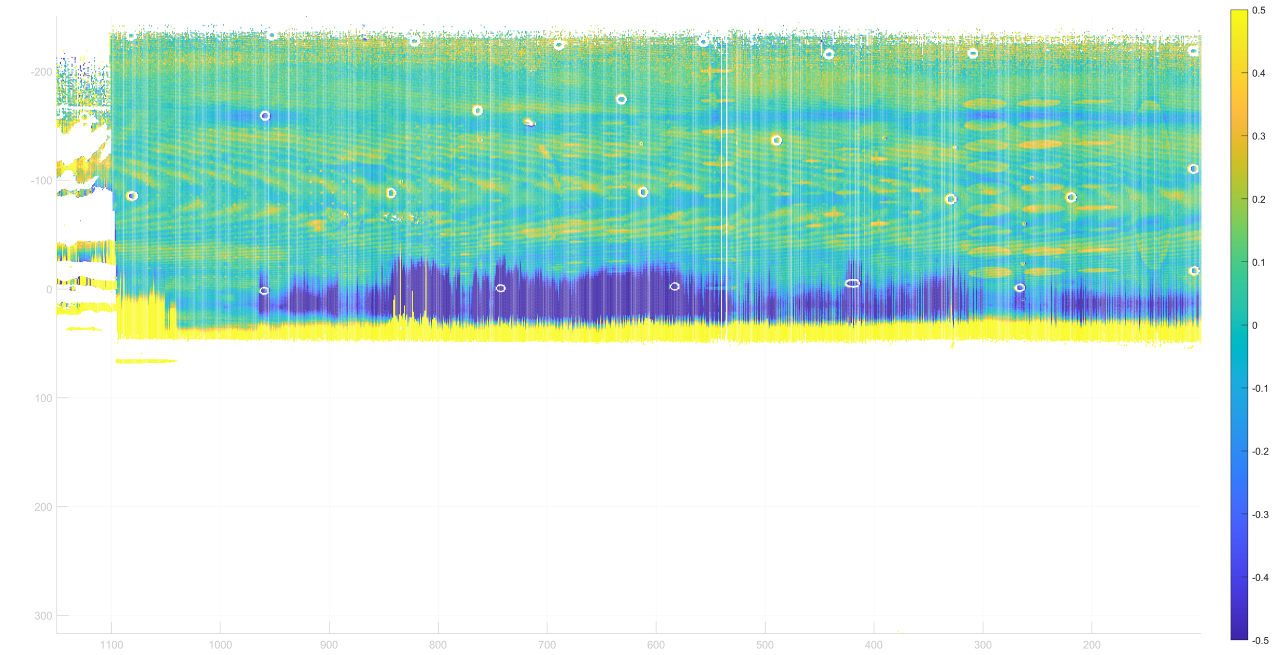

Let's reproduce that image. Directly below a *smoothed* version of the blade is imported. See the [Smoothing](#Smoothing) chapter of this notebook to see how that is done. Smoothing takes about 4 hours to complete, so that's why it is only done once, after which the results are stored in a file. The data in the smoothed file shows the delta between what the blade is supposed to look live versus what it *actually* looks like.

In [11]:
smoothed_z = np.load('smoothed_z.npy')
result_z = (smoothed_z - z) / 10 # to get results in millimeters

In [12]:
np.unique(result_z)

array([-23.99035645, -23.98675537, -23.9831543 , ...,   0.21418408,
         0.21665327,   0.22259164])

Now that we have the correct data (which went a lot faster than waiting for 4 hours!), we can actually reproduce TU Delft's image. The color scheme is a bit off since Matlab's color scheme is proprietary. But it shows the same blade with the same erosion pattern. It has also been annotated, and the individual erosion patches have been zoomed in on. Sometimes the pattern is very small, which makes the zoomed picture rather impossible to understand.

**Note**: this cell can take a few minutes to run since it needs to correctly plot millions and millions of data points.

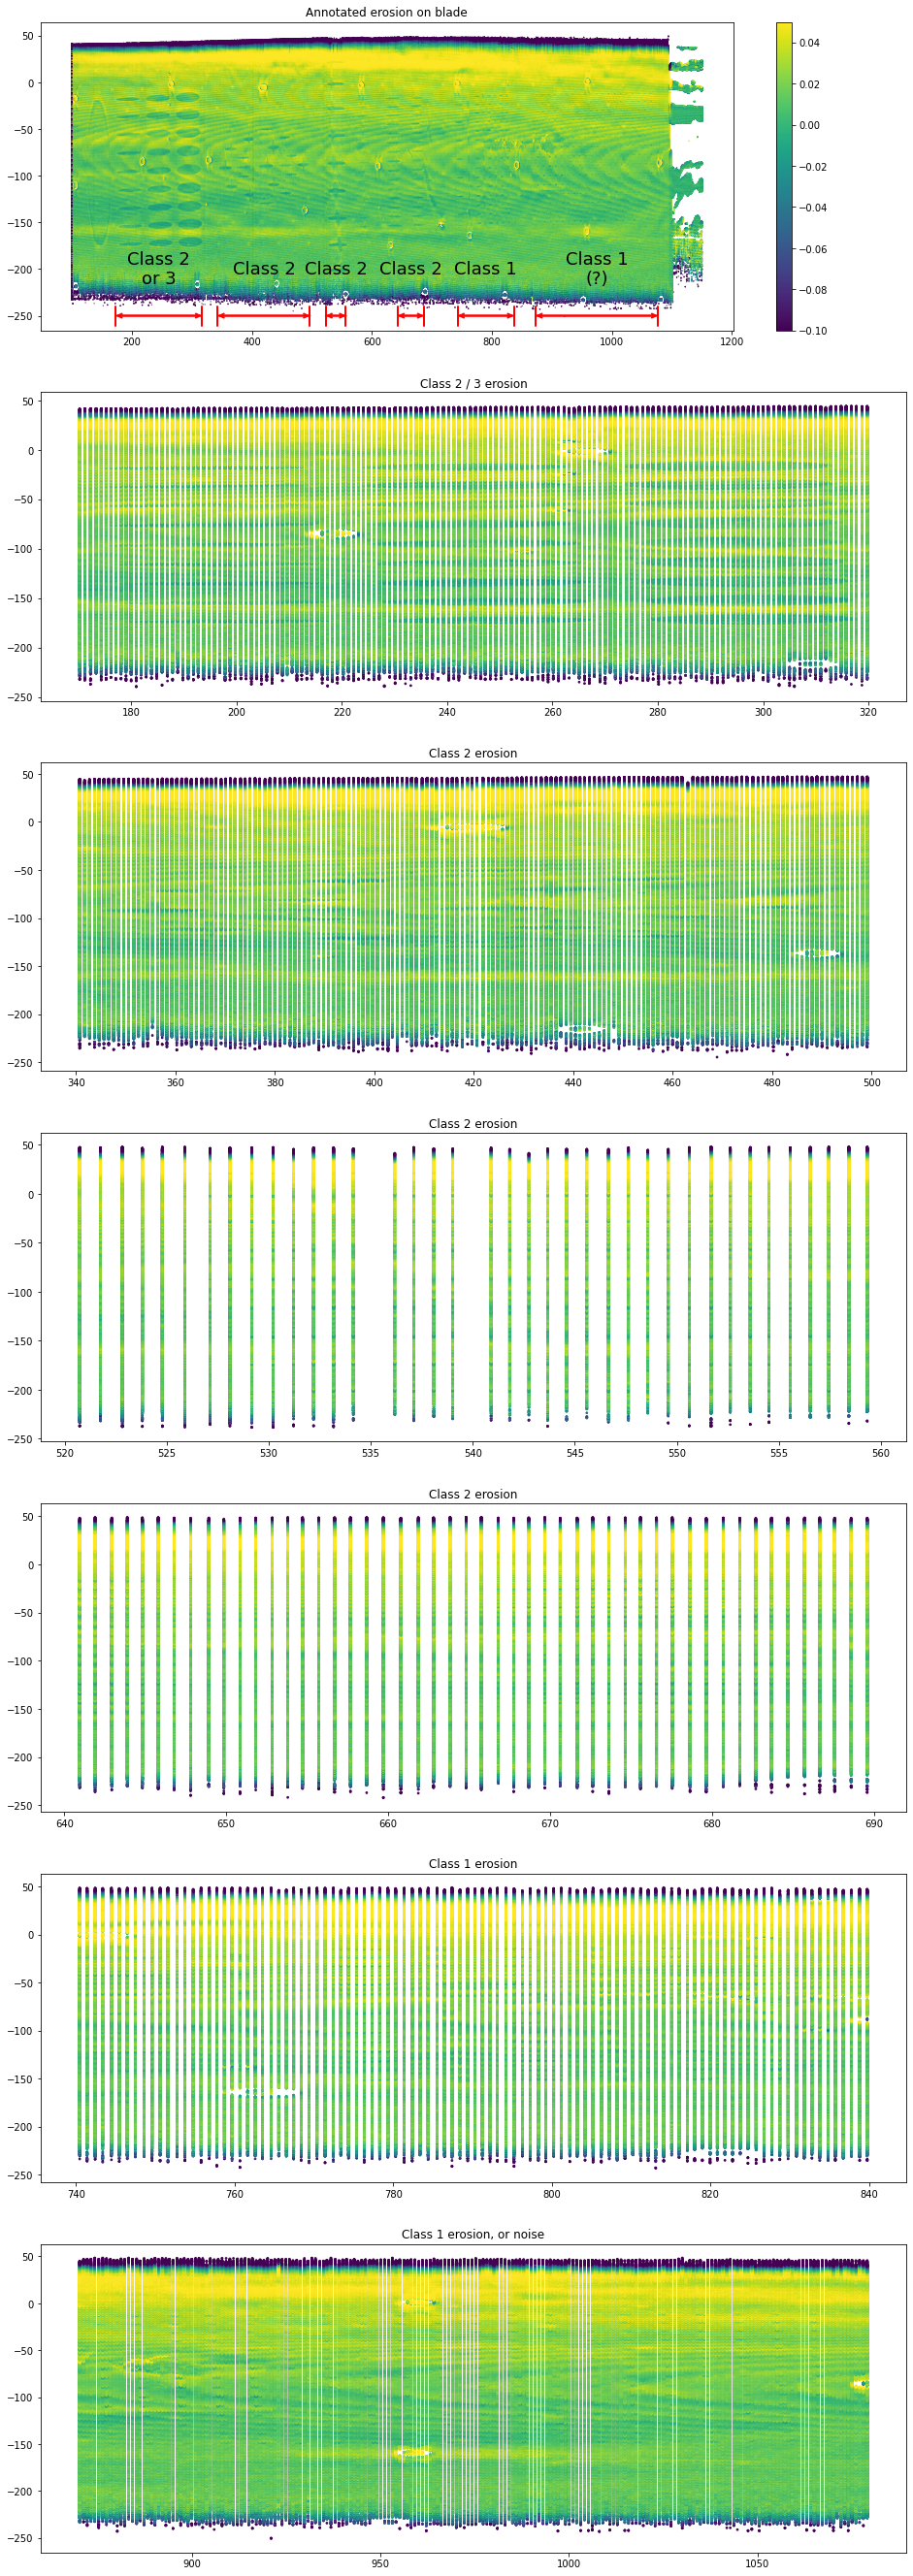

In [13]:
fig, (ax, ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(7, figsize=(16,48))
image = ax.scatter(x, y, c=result_z, s=0.1, vmin=-0.1, vmax=0.05)
ax.title.set_text('Annotated erosion on blade')
fig.colorbar(image, ax=ax)
# plt.colorbar(image)

annotation_line(
    ax = ax, 
    text='Class 2\nor 3', 
    xmin=170, 
    xmax=320, 
    y=-250, 
    ytext=-200, 
    linewidth=2, 
    linecolor='red', 
    fontsize=18
)

annotation_line(
    ax = ax, 
    text='Class 2', 
    xmin=340, 
    xmax=500, 
    y=-250, 
    ytext=-200, 
    linewidth=2, 
    linecolor='red', 
    fontsize=18
)

annotation_line(
    ax = ax, 
    text='Class 2', 
    xmin=520, 
    xmax=560, 
    y=-250, 
    ytext=-200, 
    linewidth=2, 
    linecolor='red', 
    fontsize=18
)

annotation_line(
    ax = ax, 
    text='Class 2', 
    xmin=640, 
    xmax=690, 
    y=-250, 
    ytext=-200, 
    linewidth=2, 
    linecolor='red', 
    fontsize=18
)

annotation_line(
    ax = ax, 
    text='Class 1', 
    xmin=740, 
    xmax=840, 
    y=-250, 
    ytext=-200, 
    linewidth=2, 
    linecolor='red', 
    fontsize=18
)

annotation_line(
    ax = ax, 
    text='Class 1\n(?)', 
    xmin=870, 
    xmax=1080, 
    y=-250, 
    ytext=-200, 
    linewidth=2, 
    linecolor='red', 
    fontsize=18
)

mask = (x > 170) & (x < 320)
windowed_x = x[mask]
windowed_y = y[mask]
windowed_z = result_z[mask]

ax1.scatter(windowed_x, windowed_y, c=windowed_z, s=3, vmin=-0.1, vmax=0.05)
ax1.title.set_text('Class 2 / 3 erosion')

mask = (x > 340) & (x < 500)
windowed_x = x[mask]
windowed_y = y[mask]
windowed_z = result_z[mask]

ax2.scatter(windowed_x, windowed_y, c=windowed_z, s=3, vmin=-0.1, vmax=0.05)
ax2.title.set_text('Class 2 erosion')

mask = (x > 520) & (x < 560)
windowed_x = x[mask]
windowed_y = y[mask]
windowed_z = result_z[mask]

ax3.scatter(windowed_x, windowed_y, c=windowed_z, s=3, vmin=-0.1, vmax=0.05)
ax3.title.set_text('Class 2 erosion')

mask = (x > 640) & (x < 690)
windowed_x = x[mask]
windowed_y = y[mask]
windowed_z = result_z[mask]

ax4.scatter(windowed_x, windowed_y, c=windowed_z, s=3, vmin=-0.1, vmax=0.05)
ax4.title.set_text('Class 2 erosion')

mask = (x > 740) & (x < 840)
windowed_x = x[mask]
windowed_y = y[mask]
windowed_z = result_z[mask]

ax5.scatter(windowed_x, windowed_y, c=windowed_z, s=3, vmin=-0.1, vmax=0.05)
ax5.title.set_text('Class 1 erosion')

mask = (x > 870) & (x < 1080)
windowed_x = x[mask]
windowed_y = y[mask]
windowed_z = result_z[mask]

ax6.scatter(windowed_x, windowed_y, c=windowed_z, s=3, vmin=-0.1, vmax=0.05)
ax6.title.set_text('Class 1 erosion, or noise')


# Slicing

The approach we take is to divide the blade into slices of +/- 10 millimeters. Just like a very thin cake slice! These slices, together with their corresponding erosion class are then individually fed to the machine learning algorithm to train it. After training is done, the algorithm returns a machine learning model. This model can be fed new slices, on which it will predict the erosion class. Since we use slices, we can confidently say which part of the blade has eroded. Though in reality this will be harder since the drone will not act under lab conditions.

The slices should be +/- 10 millimeters large. This corresponds with 10 "lines" of the scanner. Therefore, we can calculate the starting coordinates of each slice:

In [14]:
slice_start_coordinates = []
current_x = 0

for xi in np.unique(x)[1:]:
    if xi > current_x + 10:
        current_x = xi
        slice_start_coordinates.append(xi)

print("There are", len(slice_start_coordinates), "slices to be made")
print(slice_start_coordinates)

There are 99 slices to be made
[100.040003657341, 110.88000237941742, 121.84999883174896, 132.48999416828156, 143.38000118732452, 154.45999801158905, 165.34000635147095, 176.14999413490295, 186.89000606536865, 197.81999289989471, 208.70999991893768, 219.15000677108765, 230.11000454425812, 240.29000103473663, 251.1799931526184, 262.21001148223877, 272.9099988937378, 283.2599878311157, 293.33001375198364, 303.9900064468384, 314.7900104522705, 324.82999563217163, 335.7299864292145, 346.5900123119354, 357.36000537872314, 368.1800067424774, 379.0299892425537, 389.8099958896637, 400.6499946117401, 411.57999634742737, 421.86999320983887, 432.559996843338, 443.28999519348145, 454.1800022125244, 465.039998292923, 476.13999247550964, 487.0299994945526, 497.1500039100647, 508.01998376846313, 518.7699794769287, 529.1699767112732, 540.8999919891357, 551.6800284385681, 562.4300241470337, 573.2499957084656, 583.9400291442871, 594.539999961853, 605.400025844574, 615.4599785804749, 626.3200044631958, 6

Now that we have the start coordinates, we can actually make the slices. Note that we do create slices on the X and Y coordinate here, but we never use them afterwards. We will also "lose" one slice since the last starting coordinates are actually the end of the blade; there is nothing to be sliced after that.

In [15]:
x_slices = []
y_slices = []
z_slices = []
stop = slice_start_coordinates[-1]
current_index = 0

for coordinate in slice_start_coordinates:
    if coordinate == stop:
        break

    next_coordinate = slice_start_coordinates[current_index + 1]
    mask = (x >= coordinate) & (x < next_coordinate)

    x_slices.append(x[mask])
    y_slices.append(y[mask])
    z_slices.append(result_z[mask])
    
    current_index += 1
    
print(len(x_slices))
print(x_slices)

98
[array([101.71999782, 101.71999782, 101.71999782, ..., 108.8199988 ,
       109.87000167, 109.87000167]), array([111.90000176, 120.82000077, 111.90000176, ..., 117.94000119,
       120.82000077, 120.82000077]), array([122.75999784, 122.75999784, 122.75999784, ..., 130.55999577,
       131.49000704, 131.49000704]), array([137.31999695, 135.50999761, 135.50999761, ..., 142.15999842,
       142.15999842, 142.15999842]), array([152.38000453, 147.35999703, 149.28999543, ..., 152.38000453,
       153.33999693, 153.33999693]), array([159.37000513, 159.37000513, 159.37000513, ..., 162.41000593,
       163.38999569, 164.38999772]), array([172.26999998, 172.26999998, 172.26999998, ..., 175.22999644,
       175.22999644, 175.22999644]), array([180.95999956, 180.95999956, 180.95999956, ..., 185.8599931 ,
       185.8599931 , 185.8599931 ]), array([186.89000607, 187.84999847, 187.84999847, ..., 195.76999545,
       195.76999545, 196.83000445]), array([202.82000303, 204.72000539, 202.82000303, ..

Unfortunately, the slices have very different shapes. Some slices consist of as much as 75k data points, while others have only 50k data points. The machine learning algorithm cannot deal with this, so we will pad any slice with 0's until it has reached the maximum slice size.

https://stackoverflow.com/questions/3438756/some-built-in-to-pad-a-list-in-python

In [16]:
z_slices_padded = []
max_length_list = find_max_length_list(z_slices)

for z_slice in z_slices:
    z_slices_padded.append(pad_list_to_length_with(z_slice.tolist(), max_length_list))

# Labelling

Just the last step before we can move on to machine learning: we need to label all the individual slices with their target value. This is the erosion class that corresponds with the slice. There is a helper function at the top of the file that helps us with this. The target values were determined manually based of the large graphic of TU Delft and us in the middle of this notebook.

We use the mean to get +/- the center of the slice. 1 or 2 millimeters off is fine, since the slices measure +/- 10 millimeters.

We can see that there are 9 instances of a category 1 erosion case. This is only 10% of our data, so we might encounter problems later on when train/test splitting. It may end up putting all the category 1 erosion cases in the train set, or the test set. That leads to an unrepresentative training set and will lower the usability of the resulting machine learning model.

In [17]:
targets = []

for x_slice in x_slices:
    targets.append(get_erosion_class_based_on_x_coordinate(mean(x_slice)))
    
print(targets)

[0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Validation of the model

We have not created the model yet, but we can take steps to test the validity of it. We split all our slices into two sets: *train* and *test*. We use the train set to train the model. Afterwards, we use the test set (which our model has never seen before, that is important!) to test how good the model predicts erosion classes on new cases. Note that our dataset is rather small (98 samples) so any result should be taken with a rather large grain of salt.

In [18]:
train_data, test_data, train_labels, test_labels = train_test_split(z_slices_padded, 
                                                                    targets, 
                                                                    test_size=0.33, 
                                                                    random_state=42
                                                                   )

Fortunately, about half of the category 1 erosion cases ended up in the test set, and the other half is therefore in the training set. It's still not much to go on, but the datasets are more representative like this.

In [19]:
print(test_labels)

[1, 2, 0, 2, 0, 0, 1, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 2, 1, 0, 2, 2]


# Scaling of the data

We will transform the data in two ways, because of the machine learning algorithms that we want to use.

The first is a logistic regression, which generally trains better if all the data is scaled between [0..1]. The second is a Linear Support Vector Machine, which benefits a lot from a normally distributed dataset. The `StandardScaler` below transforms the dataset into one that has a mean of 0 and standard deviation of 1: more or less normally distributed.

**Important**: the scaler should be trained on the train data and re-used on the test data. Training a new scaler on the test data would introduce bias since both the train or test set could contain "weird" data points that the other one does not have.

In [20]:
# min_max_scaler = MinMaxScaler()
# min_max_scaler.fit(train_data)
# train_data = min_max_scaler.transform(train_data)
# test_data = min_max_scaler.transform(test_data)

standard_scaler = StandardScaler()
standard_scaler.fit(train_data)
standard_scaled_train_data = standard_scaler.transform(train_data)
standard_scaled_test_data = standard_scaler.transform(test_data)

# Benchmarking

Let's first try out the two worst case scenarios:

1. The model categorizes every slice as not eroded (category 0)
2. The model categorizes every slice as the highest class of erosion (category 2)

The reason we try this out, is because "stupid" models like these are often surprisingly good when determining their metrics. This is mostly visible in the 2nd benchmark: it scores close to 50% on accuracy, precision and recall.

It should be obvious, however, that these models would be useless in the real world. They do not predict anything, they just output a predetermined erosion category.

Accuracy is: 0.42424242424242425
Accuracy is the ratio of correct True Positives and True negatives,
This metric is always iffy since in our case it would score almost 40% by always saying that there is no erosion.

Precision is: 0.42424242424242425
Precision is the ratio of actual True Positives in the predicted Positives,
In other words: how many items that we predicted to be a class are actually of that class?

Recall is: 0.448512585812357
Recall is the ratio of predicted True Positives of all True Positives,
In other words: how many of all the True Positives did we find?



Text(0.5, 1.0, 'Predicted values vs actual values of erosion class')

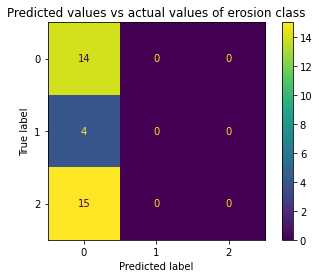

In [21]:
zero_benchmark = 33*[0]

print("Accuracy is:", accuracy_score(test_labels, zero_benchmark))
print("Accuracy is the ratio of correct True Positives and True negatives,")
print("This metric is always iffy since in our case it would score almost 40% by always saying that there is no erosion.")
print()

print("Precision is:", precision_score(test_labels, zero_benchmark, labels=test_labels, average="micro"))
print("Precision is the ratio of actual True Positives in the predicted Positives,")
print("In other words: how many items that we predicted to be a class are actually of that class?")
print()

print("Recall is:", recall_score(test_labels, zero_benchmark, labels=test_labels, average="micro"))
print("Recall is the ratio of predicted True Positives of all True Positives,")
print("In other words: how many of all the True Positives did we find?")
print()

disp = ConfusionMatrixDisplay.from_predictions(test_labels, zero_benchmark)
disp.ax_.set_title("Predicted values vs actual values of erosion class")

Accuracy is: 0.45454545454545453
Accuracy is the ratio of correct True Positives and True negatives,
This metric is always iffy since in our case it would score almost 40% by always saying that there is no erosion.

Precision is: 0.45454545454545453
Precision is the ratio of actual True Positives in the predicted Positives,
In other words: how many items that we predicted to be a class are actually of that class?

Recall is: 0.5148741418764302
Recall is the ratio of predicted True Positives of all True Positives,
In other words: how many of all the True Positives did we find?



Text(0.5, 1.0, 'Predicted values vs actual values of erosion class')

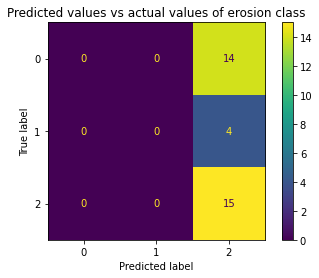

In [22]:
high_benchmark = 33*[2]

print("Accuracy is:", accuracy_score(test_labels, high_benchmark))
print("Accuracy is the ratio of correct True Positives and True negatives,")
print("This metric is always iffy since in our case it would score almost 40% by always saying that there is no erosion.")
print()

print("Precision is:", precision_score(test_labels, high_benchmark, labels=test_labels, average="micro"))
print("Precision is the ratio of actual True Positives in the predicted Positives,")
print("In other words: how many items that we predicted to be a class are actually of that class?")
print()

print("Recall is:", recall_score(test_labels, high_benchmark, labels=test_labels, average="micro"))
print("Recall is the ratio of predicted True Positives of all True Positives,")
print("In other words: how many of all the True Positives did we find?")
print()

disp = ConfusionMatrixDisplay.from_predictions(test_labels, high_benchmark)
disp.ax_.set_title("Predicted values vs actual values of erosion class")

# Machine learning

Now what we all came for! And every data scientist's deception: machine learning. Just see how many lines of code it took to get here, and how many lines it takes to actually train the models. Ah well.

We will try three different models: two linear models since the data/targets should correlate linearly, and a simple tree-based model that regularly outperforms even the most advanced machine learning algorithms.

1. **Logistic regression**: this algorithm tries to create a model by creating a linear function between the probability of an event happening (in our case: the slice in question being of category 0, 1 or 2) and the variables that should cause the event (in our case: the data in the slice itself). When fed with data, the event that is predicted to have the highest probability of happening is given back as a result. This is one of the simplest classification algorithms, but is very robust to noise and outliers because of its simplicity.
2. **Support Vector Machine**: this algorithm mathematically transforms the input data in such a way that it is able to draw nice dividing lines through the transformed datapoints. These lines are called "hyperplanes" because of the fact that the data can be transformed so much/often that it essentially in a higher dimension.
3. **Random Forest**: a collection of many regular decision trees. In our case, 100 of them. All these decision trees will be individually trained, after which they will essentially behave as a democracy. When a new data sample comes in, all the individual trees with give an output. The random forest takes the output that occurs most often within all its individual trees, and gives that as the definitive output.

We expect that the Logistic Regression and SVM will do best since the data should correlate linearly with the erosion categories (wider and deeper erosion patch = higher category of erosion), but it should be interesting to see what the Random Forest does.

In [23]:
lr = LogisticRegression(random_state=0, max_iter=1000).fit(standard_scaled_train_data, train_labels)
lr_predictions = lr.predict(standard_scaled_test_data)

Accuracy is: 0.6060606060606061
Accuracy is the ratio of correct True Positives and True negatives,
This metric is always iffy since in our case it would score almost 40% by always saying that there is no erosion.

Precision is: 0.6101694915254238
Precision is the ratio of actual True Positives in the predicted Positives,
In other words: how many items that we predicted to be a class are actually of that class?

Recall is: 0.6590389016018307
Recall is the ratio of predicted True Positives of all True Positives,
In other words: how many of all the True Positives did we find?



Text(0.5, 1.0, 'Predicted values vs actual values of erosion class')

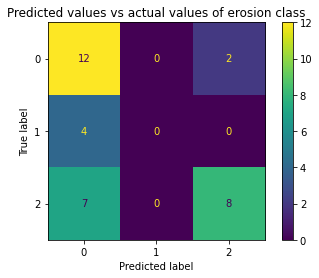

In [24]:
print("Accuracy is:", accuracy_score(test_labels, lr_predictions))
print("Accuracy is the ratio of correct True Positives and True negatives,")
print("This metric is always iffy since in our case it would score almost 40% by always saying that there is no erosion.")
print()

print("Precision is:", precision_score(test_labels, lr_predictions, labels=test_labels, average="micro"))
print("Precision is the ratio of actual True Positives in the predicted Positives,")
print("In other words: how many items that we predicted to be a class are actually of that class?")
print()

print("Recall is:", recall_score(test_labels, lr_predictions, labels=test_labels, average="micro"))
print("Recall is the ratio of predicted True Positives of all True Positives,")
print("In other words: how many of all the True Positives did we find?")
print()


disp = ConfusionMatrixDisplay.from_predictions(test_labels, lr_predictions)
disp.ax_.set_title("Predicted values vs actual values of erosion class")

documentation for svc?

In [25]:
svc = svm.SVC(random_state=0, kernel="linear").fit(standard_scaled_train_data, train_labels)
svc_predictions = svc.predict(standard_scaled_test_data)

Accuracy is: 0.6363636363636364
Accuracy is the ratio of correct True Positives and True negatives,
This metric is always iffy since in our case it would score almost 40% by always saying that there is no erosion.

Precision is: 0.6411889596602972
Precision is the ratio of actual True Positives in the predicted Positives,
In other words: how many items that we predicted to be a class are actually of that class?

Recall is: 0.6910755148741419
Recall is the ratio of predicted True Positives of all True Positives,
In other words: how many of all the True Positives did we find?



Text(0.5, 1.0, 'Predicted values vs actual values of erosion class')

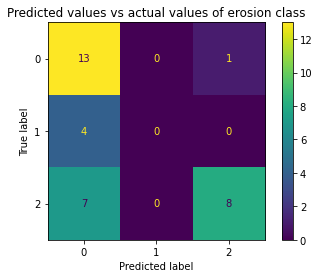

In [26]:
print("Accuracy is:", accuracy_score(test_labels, svc_predictions))
print("Accuracy is the ratio of correct True Positives and True negatives,")
print("This metric is always iffy since in our case it would score almost 40% by always saying that there is no erosion.")
print()

print("Precision is:", precision_score(test_labels, svc_predictions, labels=test_labels, average="micro"))
print("Precision is the ratio of actual True Positives in the predicted Positives,")
print("In other words: how many items that we predicted to be a class are actually of that class?")
print()

print("Recall is:", recall_score(test_labels, svc_predictions, labels=test_labels, average="micro"))
print("Recall is the ratio of predicted True Positives of all True Positives,")
print("In other words: how many of all the True Positives did we find?")
print()


disp = ConfusionMatrixDisplay.from_predictions(test_labels, svc_predictions)
disp.ax_.set_title("Predicted values vs actual values of erosion class")

In [27]:
rf = RandomForestClassifier().fit(train_data, train_labels)
rf_predictions = rf.predict(test_data)

Accuracy is: 0.5757575757575758
Accuracy is the ratio of correct True Positives and True negatives,
This metric is always iffy since in our case it would score almost 40% by always saying that there is no erosion.

Precision is: 0.5802997858672377
Precision is the ratio of actual True Positives in the predicted Positives,
In other words: how many items that we predicted to be a class are actually of that class?

Recall is: 0.620137299771167
Recall is the ratio of predicted True Positives of all True Positives,
In other words: how many of all the True Positives did we find?



Text(0.5, 1.0, 'Predicted values vs actual values of erosion class')

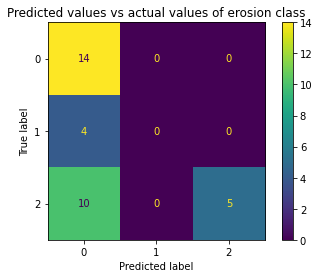

In [28]:
print("Accuracy is:", accuracy_score(test_labels, rf_predictions))
print("Accuracy is the ratio of correct True Positives and True negatives,")
print("This metric is always iffy since in our case it would score almost 40% by always saying that there is no erosion.")
print()

print("Precision is:", precision_score(test_labels, rf_predictions, labels=test_labels, average="micro"))
print("Precision is the ratio of actual True Positives in the predicted Positives,")
print("In other words: how many items that we predicted to be a class are actually of that class?")
print()

print("Recall is:", recall_score(test_labels, rf_predictions, labels=test_labels, average="micro"))
print("Recall is the ratio of predicted True Positives of all True Positives,")
print("In other words: how many of all the True Positives did we find?")
print()


disp = ConfusionMatrixDisplay.from_predictions(test_labels, rf_predictions)
disp.ax_.set_title("Predicted values vs actual values of erosion class")

# Conclusions and discussion

WP6.2 had two goals:

1. Classify arbitrary data into different categories
2. Relate available data to categories, preferably using prediction or classification models

With regards to these goals, we can draw the following conclusions:

## Classification of different categories

Together with WP1, a 5-category model with descriptions was created. This model can be found in report [I DONT KNOW? WP1 DELIVERS THIS] ranges from tiny pitholes of less than 1 millimeter wide and deep, all the way to complete delamination of the leading edge coating. WP1 has found that the laser scanner sensor will probably have troubles measuring category 1 and category 2 erosion, since the corresponding widths and depths are just too small to measure. This would also mean that our machine learning model could not predicts these categories. If there is not (reliable) data, it is impossible to train the model on it .

The scan used to create this notebook's model, however, was created in lab conditions. In these conditions the scanner is perfectly able to measure category 1 and category 2 erosion. Therefore, our model could actually train on that data. The results are not as good as we would want (100% accuracy in every case), but it shows that with enough data, the model can be trained to correctly identify even these tiny, hard to detect patches of erosion.

## Workflow

The workflow described in this notebook and in the graphic [Approach WP1 vs WP6] is one that produces results that at least partly satisfy the goals. By dividing the raw laser data into "cake slices" of +/- 10 millimeter, we are able to train machine learnings with varying degrees of success. The best performing one is a Support Vector Machine classifier following a linear kernel.

The big downside of the workflow is that processing is almost impossible to do onsite/online on the drone itself. The current dataset of 1 meter of blade takes +/- 4 hours to process on a reasonably strong laptop with 16 gigabytes of RAM and a i7-8750 CPU. This processing time is far too long for the drone to stay at the turbine that it has just scanned. Even if it had a CPU powerful enough, it would need energy to do power that CPU for hours on end. Smarter processing steps or offloading the processing to more suited CPUs (i.e. datacenter) could result in processing times that are short enough to do onsite/online.

## Model results

The Support Vector Machine model results in a precision and recall of respectively 0.64 and 0.69. As can been seen in the corresponding confusion matrix, the model is not able to correctly predict category 1 erosion and misses 7 out of 15 samples of category 2 erosion. It also misidentifies 1 non-erosion sample as a category 2 sample. The model is very good, however, at detecting when the leading as has not eroded: it correctly identifies all but 1 sample.

Given that there is more data -- the current dataset consisted of 1 meter blade with limited erosion patches, resulting in only 98 "cake slices" that could be used in machine learning --, we are confident that the model will yield much better results. We were hoping for better than coin-flip probabilities and the model is already outperforming that with a very limited dataset.

## Higher categories of erosion

The current dataset does not include category 3, 4, or 5 erosion. We believe that these are easier for the model to train on, since the erosion is deeper and wider. There is simply more of an abnormality in the data, so the model can more easily identify said abnormality. Proving that the model can be trained to identify category 1 and 2 erosion gives us faith that higher categories of erosion will be predicted just as -- probably even more -- accurately as the current categories.

# Appendices

Everything below was used to prepare the notebook, but wasn't interesting enough to keep it in the main body. As of now, it only is about the smoothing + delta calculation process of the raw data.

# Smoothing

Now we want, for every unique x-coordinate, to repeat WP1's process:

- Smooth the z-values on y-axis
- Calculate delta between smoothed z-values and actual z-values
- Display the delta

There are 1060 x-coordinates, so that means 1060 loops doing the above thing. Though we will skip the displaying until later so we only need to graph once.

In [29]:
# print('All unique values:', np.unique(x))
# print('First unique values', np.unique(x)[:10])
# print('Amount of unique values:', len(np.unique(x)))

Smoothing the values. We ignore the first x-coordinate since it contains almost 10% of all the measurements, and there is no erosion on that specific line.

**NOTE**: this `loess_1d` function assigns a weight of 0 to all values >4 standard deviations from the mean. WP1's library of choice does this to *>6* standard deviations. The only way to also use 6 stds is to write the entire function from scratch. That is hard and >4 is probably good enough for our results.

In [30]:
smoothed_z = np.zeros(z.shape)

for xi in np.unique(x)[1:]:
    print(xi, end=' ')
    mask = x==xi
    _, smoothed_z[mask], _ = loess_1d.loess_1d(y[mask], z[mask], frac=0.16)
    

In [31]:
# plt.scatter(z[mask], smoothed_z[mask])

In [32]:
# np.save('smoothed_z', smoothed_z)